# Integration of BAL object

### Import libraries

In [1]:
import os
import sys
sys.path.insert(0, "../lib")

import re
import scvi
import scanpy as sc
import numpy as np
import pandas as pd
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import sankey
import sankey_v2
import torch
import math
import seaborn as sns

Global seed set to 0


In [2]:
torch.cuda.is_available()

True

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
pd.options.display.max_rows = 200

In [5]:
# Nick needs this because he's using Firefox which apparently noone uses anymore
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

### Import datasets

In [6]:
SAMPLES = pd.read_csv("../00all-samples.csv")

In [7]:
SAMPLES = SAMPLES.loc[SAMPLES.Study.isin(['this', 'Duke'])]

In [8]:
CACHE = '../../data/31_bal-object/raw_object.h5ad'

In [9]:
def merge_data(samples):
    datasets = []
    for _, sample in samples.iterrows():
        mtx = (
            f'../../data/{sample.Directory}/cellranger/'
            f'{sample["External Sample ID"]}/outs/filtered_feature_bc_matrix'
        )
        ds = sc.read_10x_mtx(mtx)
        ds.layers['counts'] = ds.X.copy() # preserve counts
        for k, v in sample.iteritems():
            ds.obs[k] = v
        datasets.append(ds)
    return datasets[0].concatenate(datasets[1:], join='outer')

In [ ]:
if os.path.exists(CACHE):
    adata = sc.read_h5ad(CACHE)
else:
    adata = merge_data(SAMPLES)
    sc.pp.filter_genes(adata, min_counts=3)
    sc.pp.filter_cells(adata, min_counts=200)
    adata.var['mito'] = adata.var_names.str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.match('^RP(S|L)')
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mito', 'ribo'],
        percent_top=[10, 20],
        log1p=False,
        inplace=True
    )
    adata.write(CACHE)

In [11]:
adata.obs.batch.nunique()

23

In [12]:
adata.obs['External Sample ID'].nunique()

23

In [13]:
adata_raw = adata.copy()

## Feature Selection
Select 1000 HVGs using patient as the batch key.

In [14]:
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=1000,
    subset=True,
    batch_key='Patient'
)

### Setup anndata so that scvi-tools uses patient as the batch key and chemistry as covariate.

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    batch_key='Patient',
    categorical_covariate_keys=['Chemistry']
)

### Create and train model
Right now, this is commented out since I have already trained and saved a model for 1000 HVGs.

In [ ]:
model_adata = scvi.model.SCVI(adata, n_layers=2, dropout_rate=0.2, n_latent=10)

In [ ]:
model_adata.train(
    max_epochs=400,
    use_gpu=True,
    check_val_every_n_epoch=2,
    early_stopping=True
)

### Saving
Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [ ]:
model_adata.save('models/01_integration.model')

### Loading

In [15]:
model_adata = scvi.model.SCVI.load('models/01_integration.model', adata)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              


/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs']                        
INFO     Successfully registered anndata object containing 227967 cells, 1000 vars, 22       
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scvi/model/_utils.py:272: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(


### Obtaining model outputs

In [16]:
latent_adata = model_adata.get_latent_representation()

In [17]:
adata.obsm["X_scVI"] = latent_adata

### Visualization with Scanpy

In [18]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [19]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.75)

<AxesSubplot:title={'center':'leiden_scVI'}, xlabel='UMAP1', ylabel='UMAP2'>

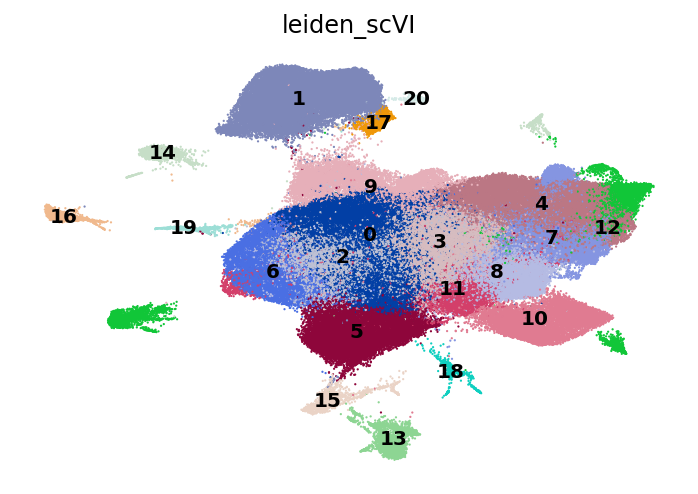

In [ ]:
sc.pl.umap(
    adata,
    color="leiden_scVI",
    frameon=False,
    legend_loc="on data",
    show=False,
    size=5
)

## Clustering by patient

<AxesSubplot:title={'center':'Leiden_scvi by Patient'}>

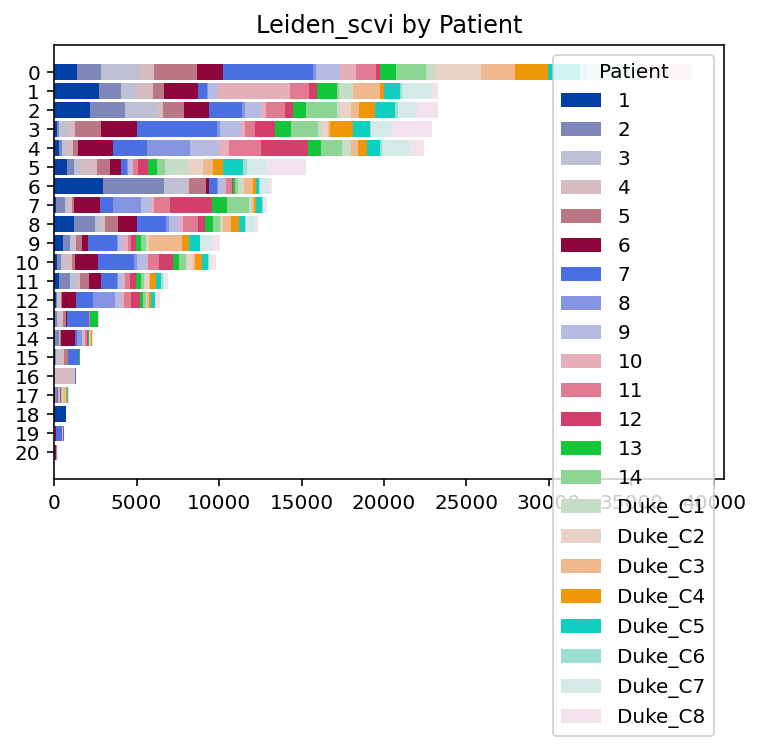

In [ ]:
sc_utils.plot_composition(
    adata,
    group_by="leiden_scVI",
    color="Patient",
)

## Clustering by chemistry

<AxesSubplot:title={'center':'Leiden_scvi by Chemistry'}>

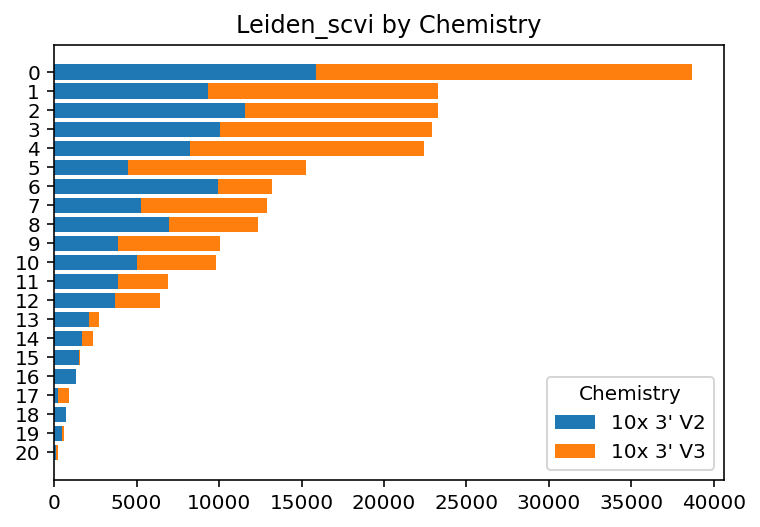

In [ ]:
sc_utils.plot_composition(
    adata,
    group_by="leiden_scVI",
    color="Chemistry",
)

## Filtering out low quality cells

<AxesSubplot:title={'center':'leiden_scVI'}, xlabel='UMAP1', ylabel='UMAP2'>

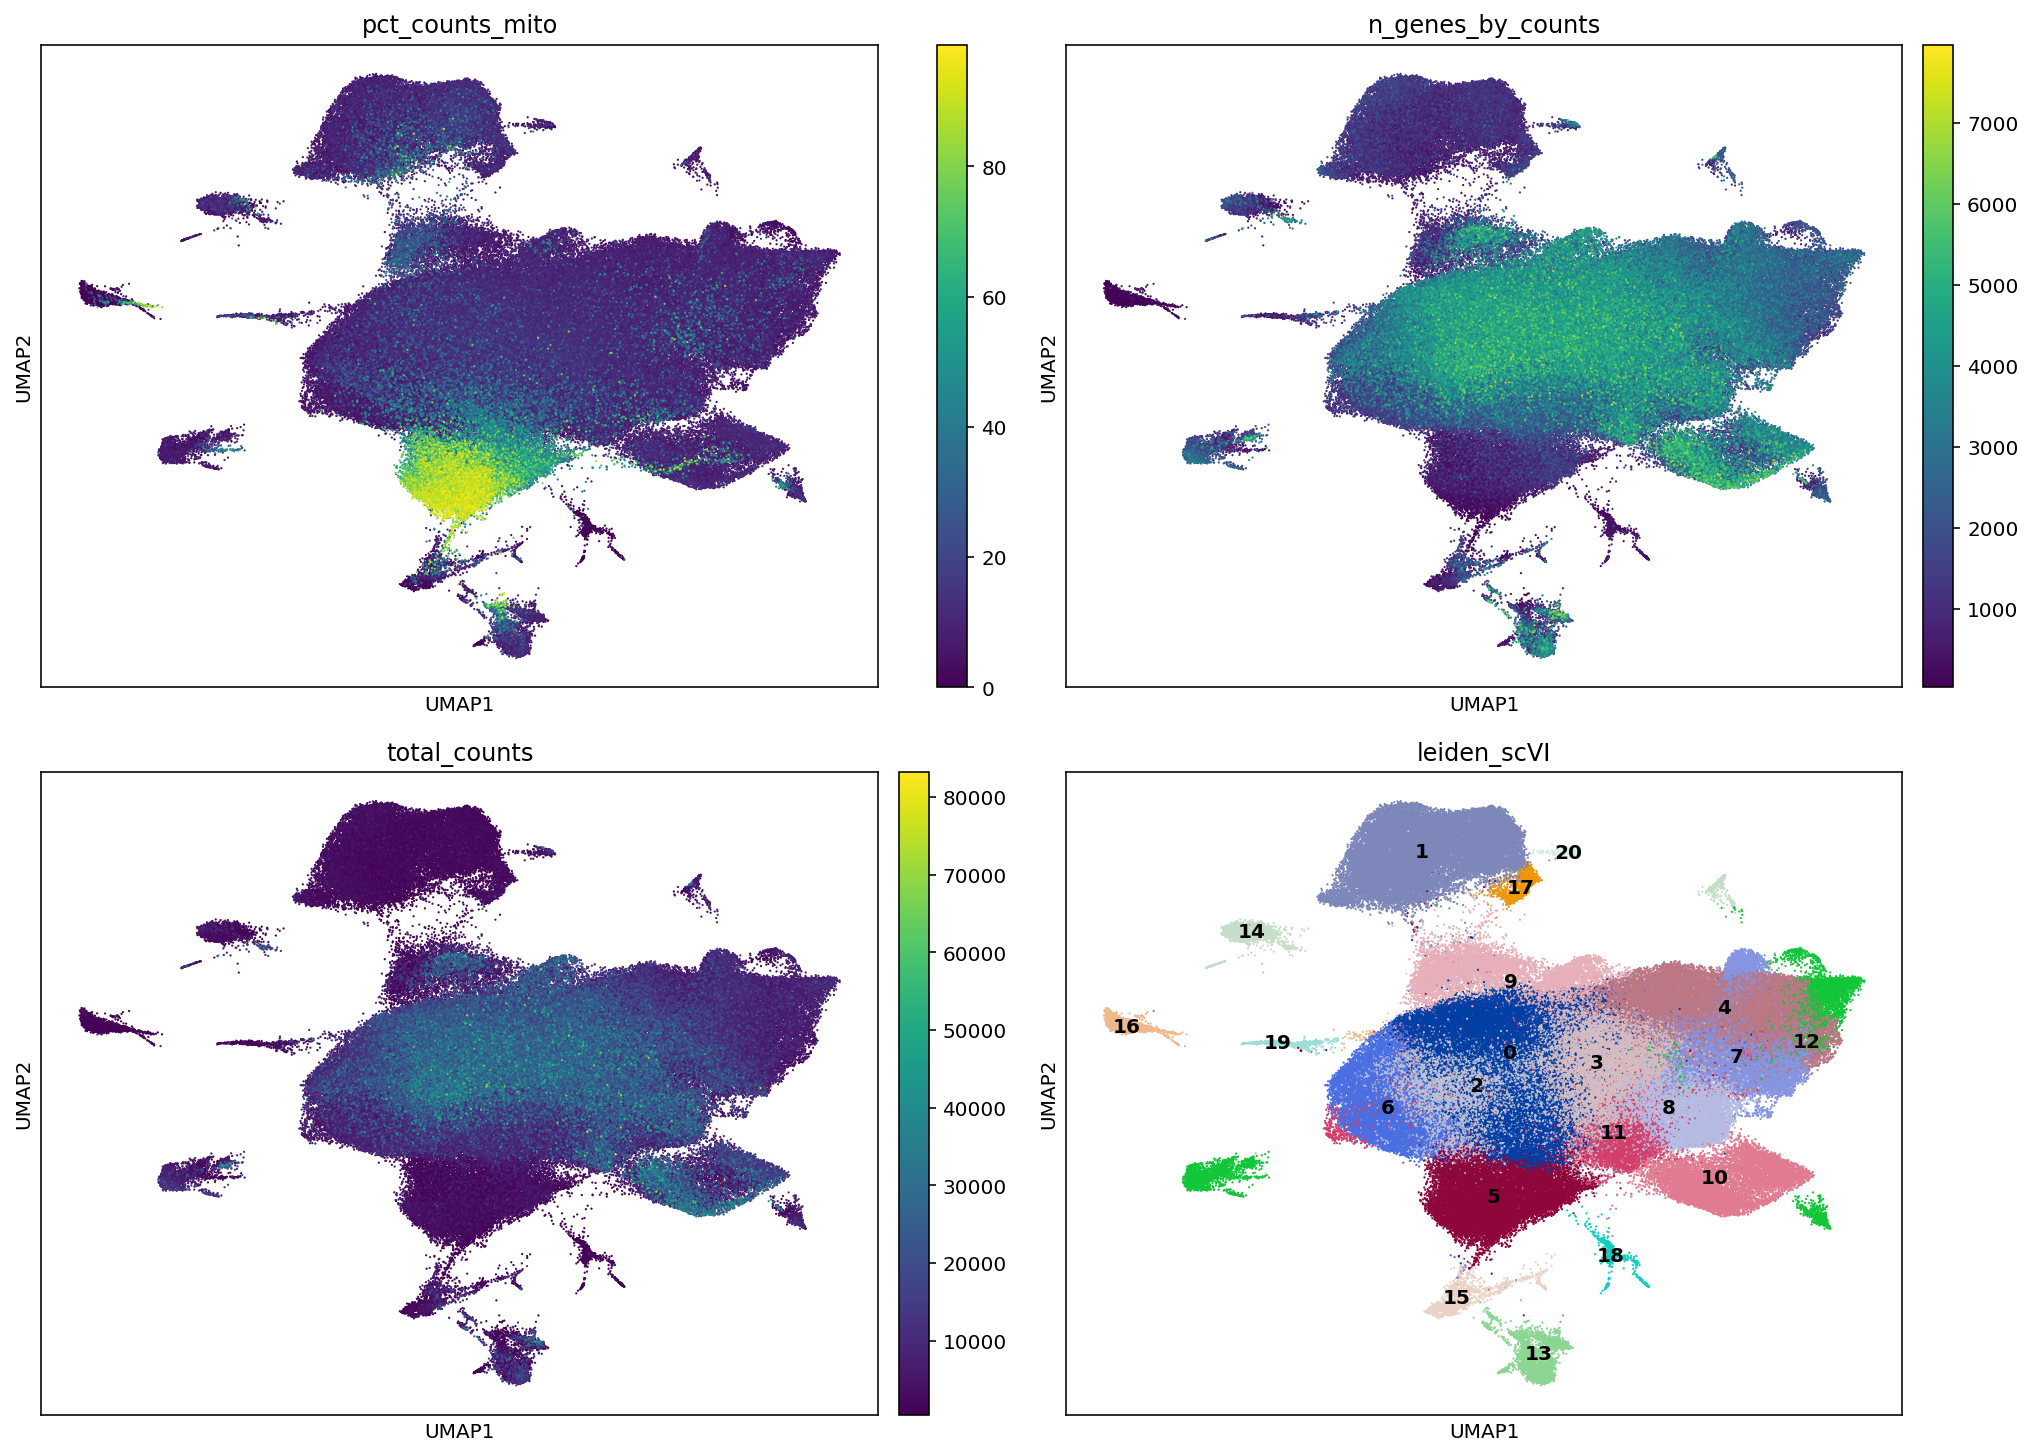

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), constrained_layout=True)

sc.pl.umap(
    adata,
    color="pct_counts_mito",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[0, 0]
)
sc.pl.umap(
    adata,
    color="n_genes_by_counts",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[0, 1]
)
sc.pl.umap(
    adata,
    color="total_counts",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[1, 0]
)
sc.pl.umap(
    adata,
    color="leiden_scVI",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[1, 1]
)

<AxesSubplot:xlabel='leiden scVI', ylabel='total_counts'>

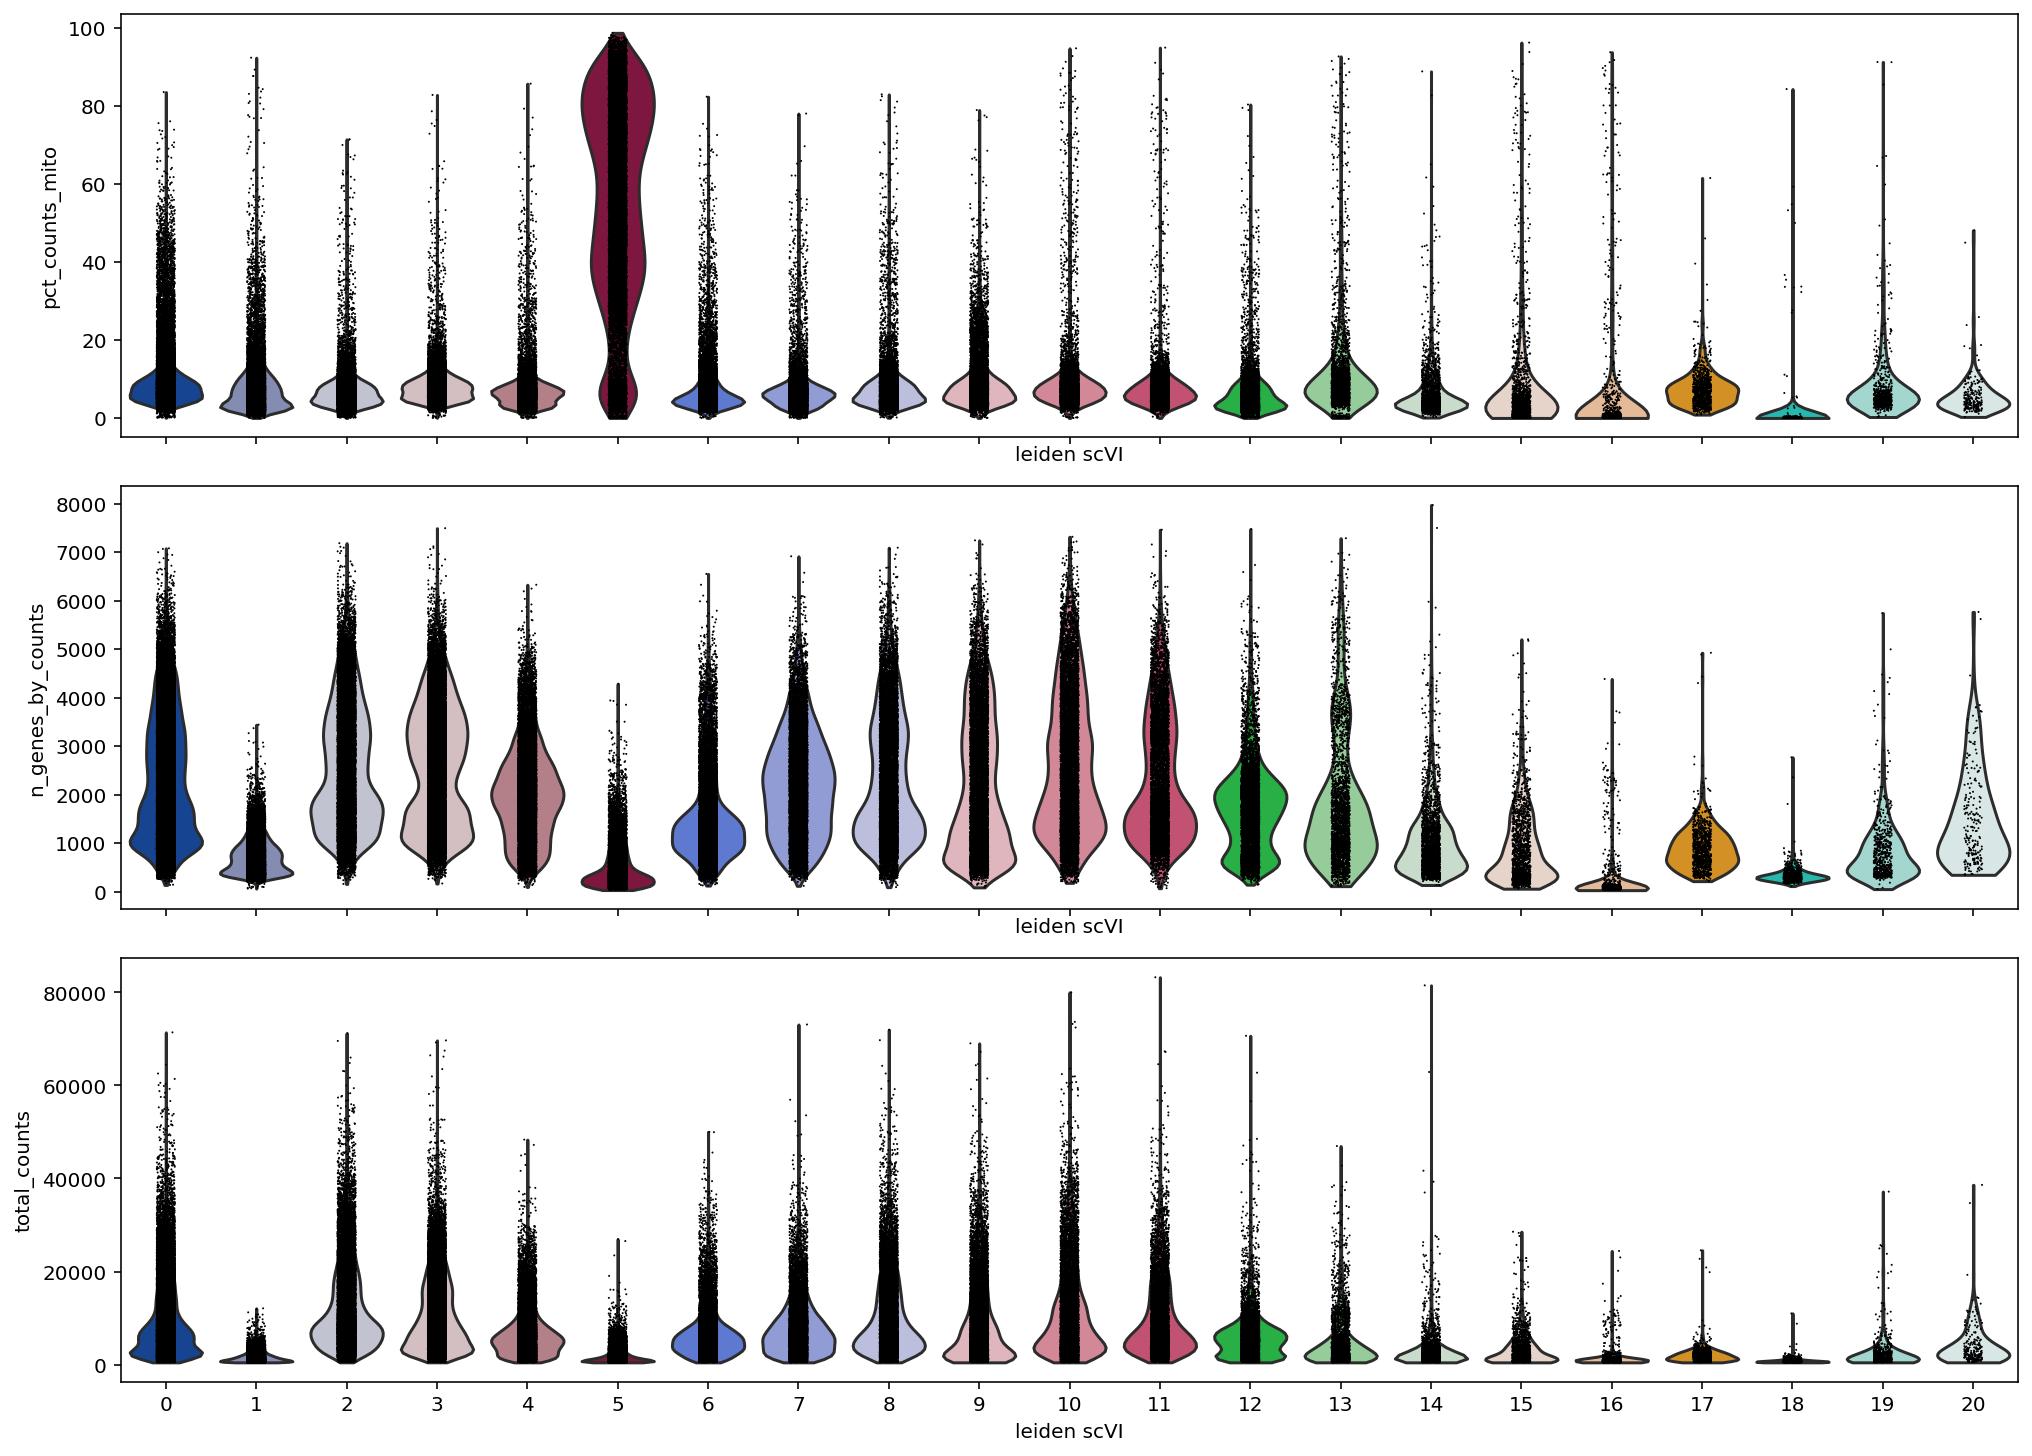

In [24]:
fig, ax = plt.subplots(nrows=3, figsize=(14, 10), constrained_layout=True, sharex=True)

sc.pl.violin(adata, "pct_counts_mito", groupby="leiden_scVI", ax=ax[0], show=False)
sc.pl.violin(adata, "n_genes_by_counts", groupby="leiden_scVI", ax=ax[1], show=False)
sc.pl.violin(adata, "total_counts", groupby="leiden_scVI", ax=ax[2], show=False)

In [25]:
adata.obs.leiden_scVI.value_counts()

0     38652
1     23265
2     23260
3     22893
4     22418
5     15281
6     13241
7     12921
8     12357
9     10047
10     9804
11     6908
12     6452
13     2730
14     2370
15     1569
16     1317
17      915
18      722
19      623
20      222
Name: leiden_scVI, dtype: int64

### Find markers

In [26]:
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)

In [27]:
adata.raw = adata_raw

In [28]:
sc.tl.rank_genes_groups(adata, "leiden_scVI", method="t-test", n_genes=200)

In [29]:
markers = sc_utils.get_markers(adata, "leiden_scVI")

In [30]:
markers.cluster = markers.cluster.astype(int)

### Display markers

In [31]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [32]:
markers.groupby("cluster").head(9)

p_val  avg_logFC     pct.1     pct.2      p_val_adj  cluster  \
69     0.000000e+00   3.232193  0.283323  0.047075   0.000000e+00        0   
39     0.000000e+00   2.464633  0.432837  0.116684   0.000000e+00        0   
177    0.000000e+00   2.333200  0.229975  0.058516   0.000000e+00        0   
3      0.000000e+00   2.176342  0.861534  0.402995   0.000000e+00        0   
100    0.000000e+00   1.916519  0.345416  0.115194   0.000000e+00        0   
116    0.000000e+00   1.824836  0.357032  0.124259   0.000000e+00        0   
0      0.000000e+00   1.749259  0.995783  0.781238   0.000000e+00        0   
96     0.000000e+00   1.693965  0.425981  0.176019   0.000000e+00        0   
89     0.000000e+00   1.693940  0.436148  0.194903   0.000000e+00        0   
201    0.000000e+00   7.083337  0.751644  0.039746   0.000000e+00        1   
299    0.000000e+00   6.974527  0.162863  0.003600   0.000000e+00        1   
204    0.000000e+00   6.945563  0.587965  0.020430   0.000000e+00        1   
210    0.000000e+00   6.833026  0.463142  0.012887   0.000000e+00        1   
203    0.000000e+00   6.823329  0.608382  0.038163   0.000000e+00        1   
293    0.000000e+00   6.667644  0.164840  0.004304   0.000000e+00        1   
283    0.000000e+00   6.502680  0.183538  0.004631   0.000000e+00        1   
212    0.000000e+00   6.356651  0.451408  0.017484   0.000000e+00        1   
228    0.000000e+00   6.352354  0.339996  0.011954   0.000000e+00        1   
403    0.000000e+00   2.465870  0.989854  0.716219   0.000000e+00        2   
431    0.000000e+00   2.332847  0.664832  0.262810   0.000000e+00        2   
544    0.000000e+00   2.291140  0.373345  0.105751   0.000000e+00        2   
408    0.000000e+00   2.284402  0.917627  0.479622   0.000000e+00        2   
400    0.000000e+00   2.264793  0.999785  0.856854   0.000000e+00        2   
401    0.000000e+00   2.043346  0.985985  0.662386   0.000000e+00        2   
502    0.000000e+00   1.840408  0.529020  0.206114   0.000000e+00        2   
411    0.000000e+00   1.767828  0.935039  0.565139   0.000000e+00        2   
521    0.000000e+00   1.727584  0.454815  0.169989   0.000000e+00        2   
606    0.000000e+00   2.299239  0.916001  0.589846   0.000000e+00        3   
601    0.000000e+00   2.101514  0.975888  0.684538   0.000000e+00        3   
600    0.000000e+00   1.770728  0.980955  0.660605   0.000000e+00        3   
605    0.000000e+00   1.656061  0.967545  0.679033   0.000000e+00        3   
637    0.000000e+00   1.603592  0.846329  0.439929   0.000000e+00        3   
604    0.000000e+00   1.568665  0.990215  0.769781   0.000000e+00        3   
643    0.000000e+00   1.513778  0.905561  0.574188   0.000000e+00        3   
602    0.000000e+00   1.512904  0.995282  0.797780   0.000000e+00        3   
642    0.000000e+00   1.488492  0.839820  0.515906   0.000000e+00        3   
810    0.000000e+00   4.392051  0.556116  0.069847   0.000000e+00        4   
802    0.000000e+00   3.473326  0.675752  0.179300   0.000000e+00        4   
829    0.000000e+00   3.448539  0.439691  0.073467   0.000000e+00        4   
928    0.000000e+00   3.279309  0.213846  0.028013   0.000000e+00        4   
841    0.000000e+00   3.276333  0.384245  0.064097   0.000000e+00        4   
934    0.000000e+00   2.878605  0.257561  0.054863   0.000000e+00        4   
882    0.000000e+00   2.703423  0.301900  0.077553   0.000000e+00        4   
871    0.000000e+00   2.598347  0.356767  0.093126   0.000000e+00        4   
897    0.000000e+00   2.299301  0.345838  0.124476   0.000000e+00        4   
1010   0.000000e+00   3.293711  0.773379  0.496469   0.000000e+00        5   
1013   0.000000e+00   3.272561  0.506119  0.238887   0.000000e+00        5   
1005   0.000000e+00   3.041141  0.989660  0.981508   0.000000e+00        5   
1006   0.000000e+00   3.020703  0.990969  0.979308   0.000000e+00        5   
1012   0.000000e+00   3.013372  0.671095  0.422618   0.000000e+00        5   
1154   1.952572e-09   2.982798  0.00

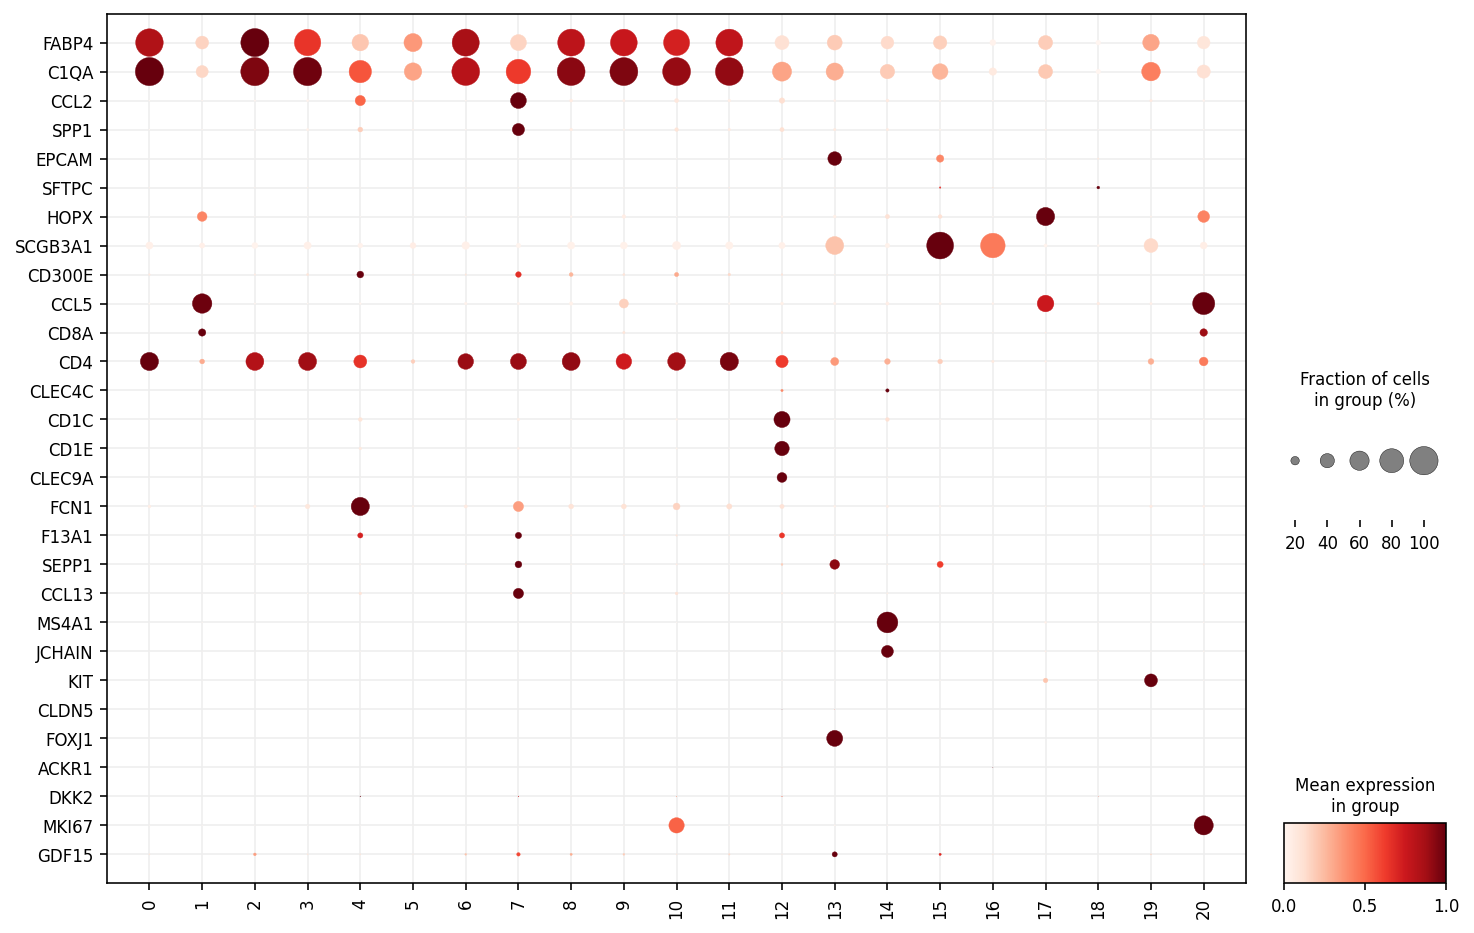

In [ ]:
ax = sc.pl.dotplot(
    adata,
    ["FABP4",  "C1QA", "CCL2", "SPP1", "EPCAM", "SFTPC", "HOPX", "SCGB3A1", "CD300E",
     "CCL5", "CD8A", "CD4", "CLEC4C", "CD1C", "CD1E", "CLEC9A", "FCN1", "F13A1", "SEPP1", "CCL13",
     "MS4A1", "JCHAIN", "KIT", "CLDN5", "FOXJ1",
     "ACKR1", "DKK2", "MKI67", "GDF15"],
    "leiden_scVI",
    swap_axes=True,
    figsize=(12, 8),
    standard_scale="var",
    edgecolor=None,
    show=False,
    zorder=2
)
ax["mainplot_ax"].grid(c="#eeeeee", zorder=0)

<AxesSubplot:title={'center':'FABP4'}, xlabel='UMAP1', ylabel='UMAP2'>

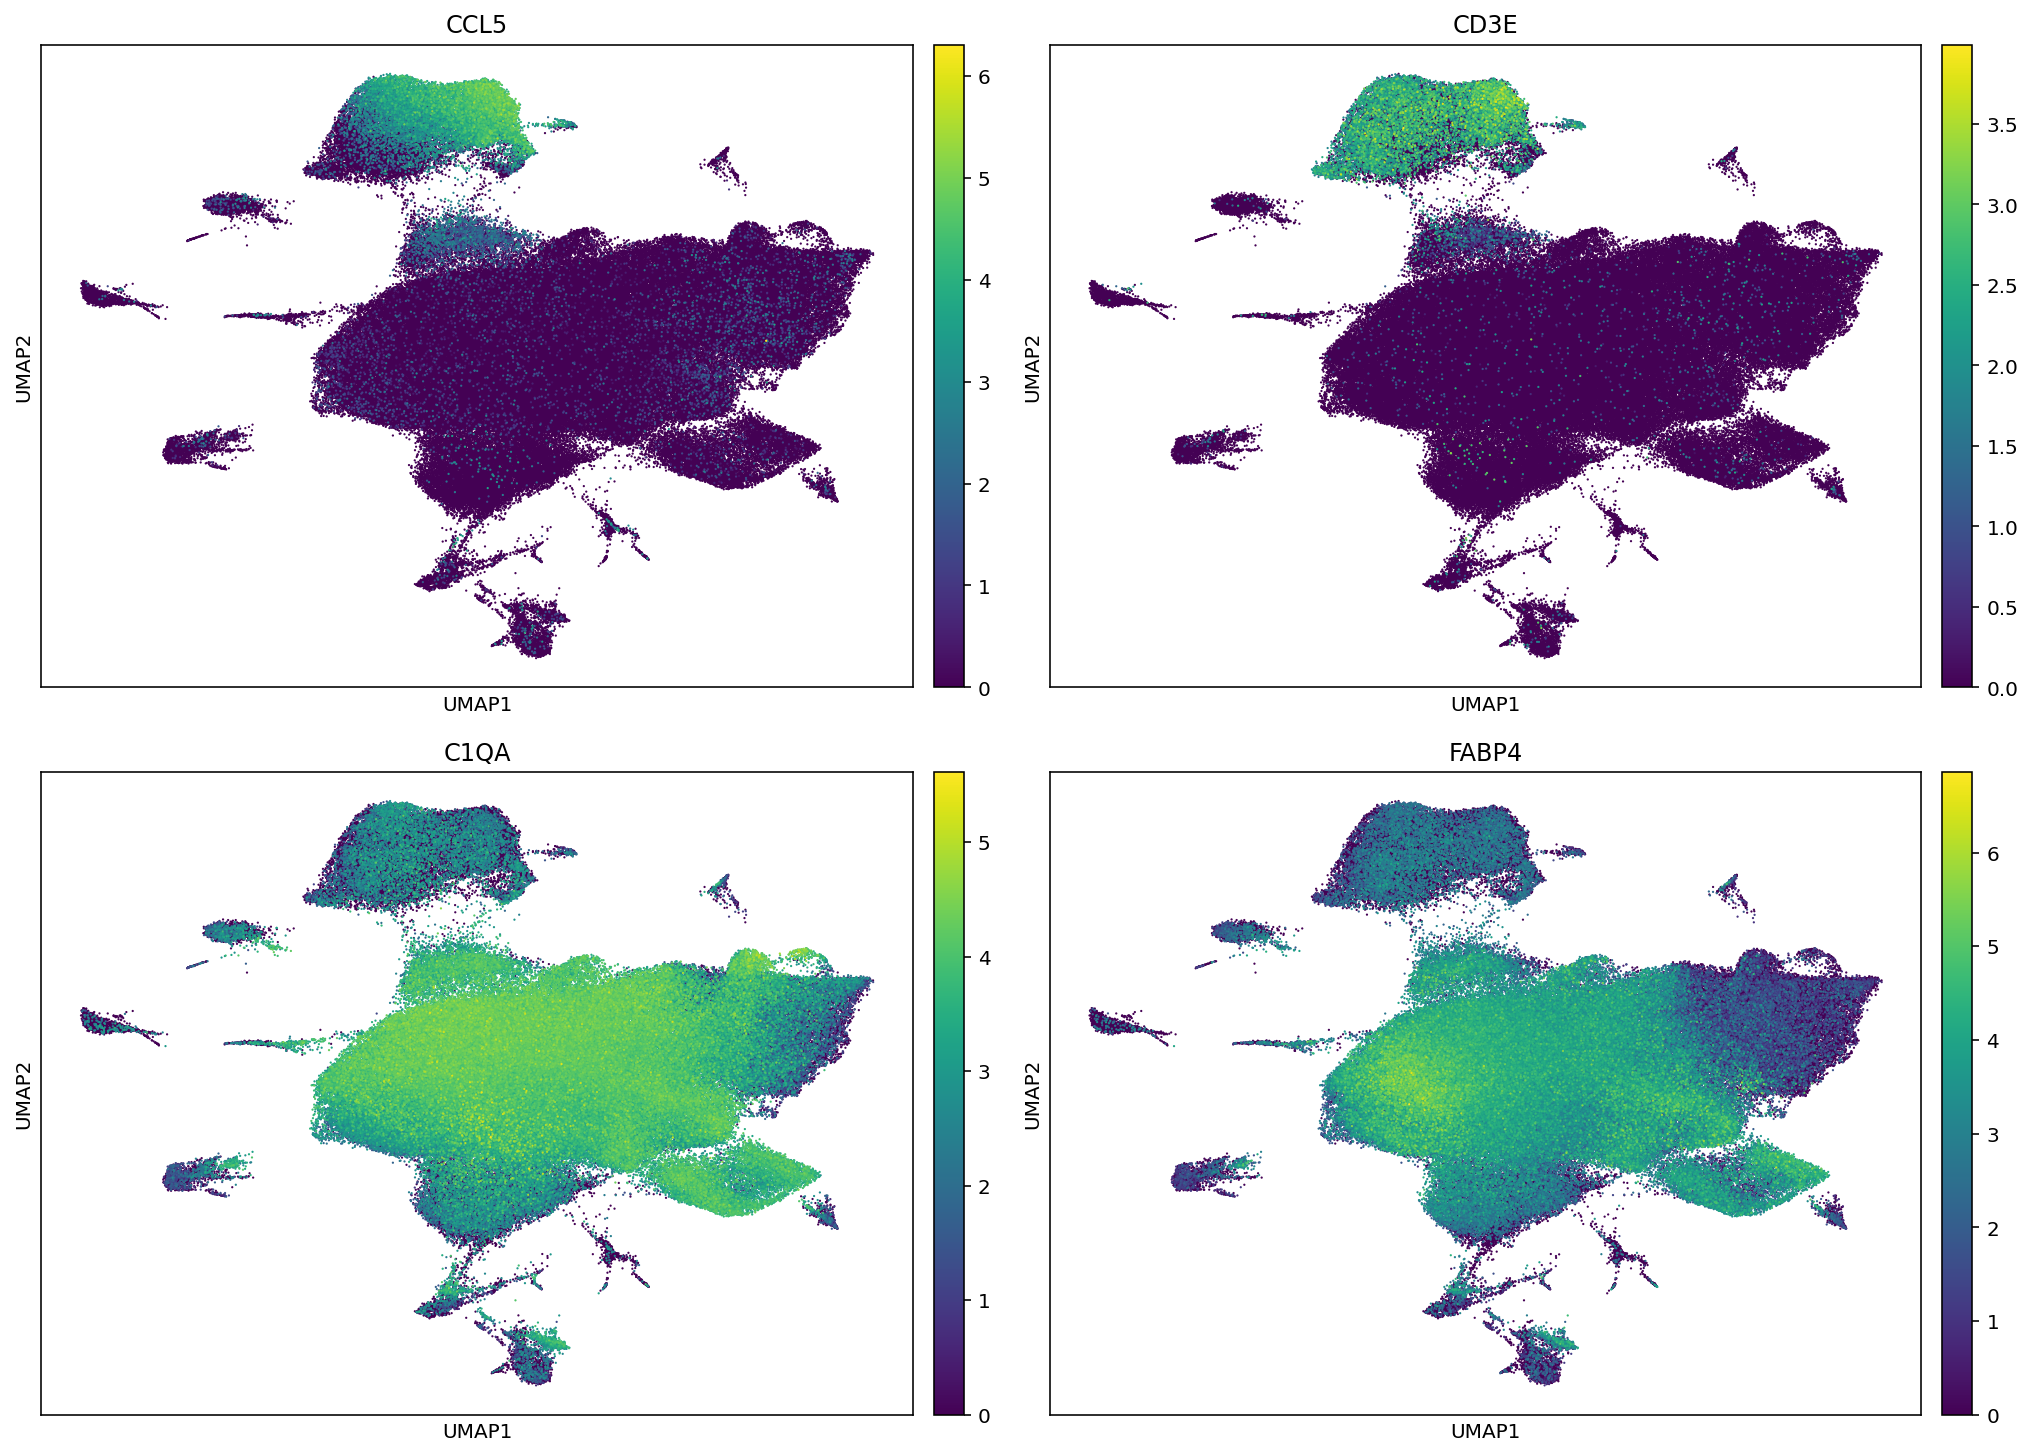

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), constrained_layout=True)

sc.pl.umap(
    adata,
    color="CCL5",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[0, 0]
)
sc.pl.umap(
    adata,
    color="CD3E",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[0, 1]
)
sc.pl.umap(
    adata,
    color="C1QA",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[1, 0]
)
sc.pl.umap(
    adata,
    color="FABP4",
    legend_loc="on data",
    size=5,
    show=False,
    ax=ax[1, 1]
)

### Save object

In [34]:
adata.write(f"../../data/31_bal-object/01_integrated.h5ad")